# Instagram Reels Engagement Analysis

### Setting up the libraries required

In [59]:
import instaloader as ins
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timezone
import random, time, re, os
import statsmodels.api as sm
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from http.cookiejar import MozillaCookieJar
from requests.cookies import RequestsCookieJar
from instaloader.exceptions import ConnectionException

### loading the Creators Dataset file
We read Creators.txt, which includes each creator’s username and genre, and use .head() to quickly check the data

In [65]:
creators_df=pd.read_csv('Creators.txt')
creators_df.head()

,username,genre
0,mridul_sharmaa,Fashion
1,alfiyakarimkhan_,Fashion
2,thatquirkymiss,Fashion
3,komalpandeyofficial,Fashion
4,_thefashionpsychic_,Fashion


In [60]:
Creators=df['username'].tolist()
Genre_map=dict(zip(df['username'],df['genre']))

A dictionary is created using zip() to map each username to its genre, making genre lookup fast during analysis.

In [61]:
# helper function for knowing post is reel or not, for extracting the hashtag
def is_post_reel(post):
    '''
        to check if the given post is reel or not 
    '''
    if post.is_video and post.video_view_count is not None:
        return True
    else:
        return False


Hashtag_pattern=re.compile(r"(#\w+)",flags=re.UNICODE)
def extract_hashtags(text):
    if not isinstance(text,str) or not text:
        return []
    tags=[t.strip('#').lower() for t in Hashtag_pattern.findall(text)]
    output=[]
    for t in tags:
        if t not in output:
            output.append(t)
    return output

Here I wrote two small helper functions.
- First one is_post_reel() just checks if the post is actually a reel (means it’s a video and has view count).
- Second one extract_hashtags() pulls all hashtags from the caption, cleans them, makes them lowercase, and keeps only unique ones.
I’ll use these later for my EDA and analysis.

### Loading Cookies and Quick Login Test

In [56]:
COOKIE_FILE = "www.instagram.com_cookies.txt"   
# Reading the Netscape-format cookies.txt
moz_cj = MozillaCookieJar()
moz_cj.load(COOKIE_FILE, ignore_discard=True, ignore_expires=True)

# Convert to a RequestsCookieJar (what Instaloader/requests uses)
req_cj = RequestsCookieJar()
for c in moz_cj:
    req_cj.set(c.name, c.value, domain=c.domain, path=c.path)

# Create Instaloader and inject cookies
L = ins.Instaloader(download_pictures=False,
                    download_videos=False,
                    download_video_thumbnails=False)

L.context._session.cookies = req_cj   # injecting cookies from browser

# Quick checking
print("Logged in as:", L.test_login())

# light test on one profile (no downloads)
u = creators[0]
p = ins.Profile.from_username(L.context, u)
print("Profile OK:", p.username, "| followers:", p.followers, "| posts:", p.mediacount)


Logged in as: kushal7634
Profile OK: mridul_sharmaa | followers: 244858 | posts: 2042


Here I’m basically loading my Instagram cookies so Instaloader logs in with my browser session. After converting the cookies, I inject them into Instaloader and just test if the login worked. Then I check one creator’s profile to confirm everything is running fine.

### Testing First Creator's Reels

In [38]:
u = creators[0]   # testing the first creator 

profile = ins.Profile.from_username(L.context, u)
print("Profile OK:", profile.username, "| followers:", profile.followers, "| posts:", profile.mediacount)

# print 3 most recent reels metadata 
count = 0
for post in profile.get_posts():
    # filtering only reels (video + view count)
    if not (getattr(post, "is_video", False) and getattr(post, "video_view_count", None)):
        continue
    print("shortcode:", post.shortcode,
          "date:", post.date_utc.replace(tzinfo=timezone.utc).isoformat(),
          "likes:", post.likes, "plays:", getattr(post, "video_view_count", None))
    count += 1
    if count >= 3:
        break


Profile OK: mridul_sharmaa | followers: 244847 | posts: 2042


JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]


shortcode: DQy6eeODAiZ date: 2025-11-08T12:32:54+00:00 likes: 8727 plays: 51291


JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]


shortcode: DQweF81j6u2 date: 2025-11-07T13:54:42+00:00 likes: 16913 plays: 166506


JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]


shortcode: DQt7XYzjxzE date: 2025-11-06T14:01:49+00:00 likes: 4535 plays: 25030


Here I’m just checking the first creator to see if everything is working. I load their profile, print their basics, and then grab the first 3 reels (only real reels based on video + views). For each reel, I print shortcode, date, likes, and plays just to confirm the scraper is pulling correct data.

### Saving the Scraped Reels Data

In [58]:
def save_rows(rows):
    if not rows:
        print("No rows to save.")
        return

    filename = "reels_data.csv"
    df = pd.DataFrame(rows)

    # if file exists, append without headers
    if os.path.exists(filename):
        df.to_csv(filename, mode='a', header=False, index=False, encoding='utf-8-sig')
    else:
        df.to_csv(filename, index=False, encoding='utf-8-sig')

Here I made a small function to save all the scraped rows into a CSV file. If there are no rows, it just warns me. If the file already exists, it will simply append new data without rewriting the headers. Otherwise, it creates a fresh reels_data.csv. Basically, this keeps adding all my scraped reels in one place.

### Data Collection

In [63]:
max_creators=len(Creators)
max_reel_per_creator=20
post_sleep=(2.5,4.5)
creator_sleep=(12,20)
backoff_minutes=8

for c in Creators:
    print(f"\n Collecting reels for @{c}| Genre={genre_map.get(c, 'Unknown')}")
    rows=[]
    count=0
    backoff=backoff_minutes
    try:
        profile=ins.Profile.from_username(L.context, c)
        followers=profile.followers
    except Exception as e:
        print('would not be able to load profile')
        continue
    try:
        for post in profile.get_posts():
            if count>=max_reel_per_creator:
                break
            if is_post_reel(post)==False:
                continue
            url = f"https://www.instagram.com/reel/{post.shortcode}/"
            caption=post.caption or ""
            hashtags=extract_hashtags(caption)
            row={
                'Username': c,
                'Genre':genre_map.get(c,'Unknown'),
                'Followers':followers,
                'Post_url':url,
                'Post_date':post.date_utc.replace(tzinfo=timezone.utc).isoformat(),
                'Likes':post.likes,
                'Comments':post.comments,
                'Plays': getattr(post,'video_view_count',None),
                'Video_Duration_sec': getattr(post,'video_duration',None),
                'Caption':caption,
                'Hashtags':','.join(hashtags),
                'CaptionLength': len(caption),
                'PostingHour':post.date_utc.hour
            }
            rows.append(row)
            count+=1
            time.sleep(random.uniform(*post_sleep))
    except ConnectionException as e:
        print('Throttled by instagram',e)
        save_rows(rows)
        print(f" Waiting {backoff} minutes before continuing...")
        time.sleep(backoff * 60)
        backoff = min(backoff * 2, 60)
        continue
    save_rows(rows)
    print(f"Done: {count} reels collected for @{c}")
    time.sleep(random.uniform(*creator_sleep))6

JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @mridul_sharmaa



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @alfiyakarimkhan_



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @thatquirkymiss



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @komalpandeyofficial



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @_thefashionpsychic_



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @tech_iela



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @the.datascience.gal



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @technicalguruji



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @aashna.talks



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @japnitahuja



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @brindasharma



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @srish_teee



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @tanyakhanijow



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @kritika_goel



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @elises.traveldiary



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @casarthakahuja



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @dr.yokesharul



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @overseasstudentsaustralia



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @kk.create



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @yudi.j



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @tradereboot_official



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @figuringout.co



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @sujithreddygopu



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @financewithsharan



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @iamnehanagar



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @natsoverfood



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @rafmazcooks



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @hariscookbook



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @peekmyfood



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @ammi.ke.khane



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @fit.khurana



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @harshalifts



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @wowfitvibha



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @brooke.paige.fit



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @fitxfearless



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @chutiyapa_begins_from_here



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @_sillyworld_



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @memezar



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @vintage_telugu_memes



JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to graphql/query: 403 Forbidden when accessing https://www.instagram.com/graphql/query [retrying; skip with ^C]
JSON Query to gr

  ✅ Done: 20 reels collected for @filmy_mag


Here I’m just looping over every creator and collecting up to 20 reels. I load their profile, filter only real reels, pull all the details (likes, comments, plays, caption, hashtags, etc.), and store everything in a row. I also use small sleep times so Instagram doesn’t block me. If it throttles, I save the data, wait, and continue. After each creator, I save all their reels to the CSV.

### Loading the Scraped Reels Data

In [3]:
insta_data=pd.read_csv('reels_data.csv')
insta_data.head(10)

,Username,Genre,Followers,Post_url,Post_date,Likes,Comments,Plays,Video_Duration_sec,Caption,Hashtags,CaptionLength,PostingHour
0,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQy6eeODAiZ/,2025-11-08T12:32:54+00:00,9021,92,53878,84.543,rate my look using ‘💖’\n\nOutfit - @sowhot.in ...,NaN,163,12
1,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQweF81j6u2/,2025-11-07T13:54:42+00:00,17072,92,168528,110.110,POV: @samantharuthprabhuoffl decodes your ENER...,NaN,293,13
2,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQt7XYzjxzE/,2025-11-06T14:01:49+00:00,4542,38,25071,14.188,Curating our calm in the dreamiest Washington ...,"ad,airbnbpartner",636,14
3,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQmfpg0jPSq/,2025-11-03T16:46:06+00:00,21547,64,431805,97.600,would you try the dusting powder hack?,NaN,38,16
4,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQhRtsQDBG6/,2025-11-01T16:10:02+00:00,5072,309,38341,27.466,"As a Certified Serial Chiller, I swear we coul...","airbnb,airbnbpartner",435,16
5,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQesA68DPu6/,2025-10-31T16:33:30+00:00,4013,151,35736,64.680,"Hey Bestie! The Girl Math Hotline is now OPEN,...","ad,olay,newolay7in1,olayindia,olay7in1range,ol...",466,16
6,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQZlfdaDBtC/,2025-10-29T16:26:41+00:00,16864,91,98758,12.722,Gentle reminder to take your parents out on a ...,NaN,79,16
7,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQWsDVpDEGP/,2025-10-28T13:26:33+00:00,8333,188,88651,40.750,that was a breeze🤭 \n\nhow many were you able ...,NaN,53,13
8,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQUb-uEjz4U/,2025-10-27T16:28:10+00:00,14463,131,171253,61.700,Post-festivity fatigue is so real!\nSlowly get...,ad,296,16
9,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQHiAvtDOMU/,2025-10-22T16:12:39+00:00,6206,166,56771,67.268,✨Festive glow unlocked✨ \n\nMy skin’s new obse...,"dalbaindia,dalba,dalbasprayserum,diwalitransit...",494,16


Here I’m loading my reels_data.csv back into a DataFrame to start my EDA.

### Starting My EDA Analysis

Now I’m beginning the EDA part exploring the dataset, checking its size, structure, and understanding what insights I can get from the scraped reels.

Checking the dataset, it has 800 rows and 13 columns

In [4]:
insta_data.shape

(800, 13)

### Data Overview

In [5]:
insta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Username            800 non-null    object 
 1   Genre               800 non-null    object 
 2   Followers           800 non-null    int64  
 3   Post_url            800 non-null    object 
 4   Post_date           800 non-null    object 
 5   Likes               800 non-null    int64  
 6   Comments            800 non-null    int64  
 7   Plays               800 non-null    int64  
 8   Video_Duration_sec  800 non-null    float64
 9   Caption             797 non-null    object 
 10  Hashtags            434 non-null    object 
 11  CaptionLength       800 non-null    int64  
 12  PostingHour         800 non-null    int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 81.4+ KB


This shows me each column, its datatype, and how many non-null values it has.

### Converting Post_date to Datetime

In [6]:
insta_data['Post_date']= pd.to_datetime(insta_data['Post_date'],errors='coerce')
insta_data.dtypes

Username                           object
Genre                              object
Followers                           int64
Post_url                           object
Post_date             datetime64[ns, UTC]
Likes                               int64
Comments                            int64
Plays                               int64
Video_Duration_sec                float64
Caption                            object
Hashtags                           object
CaptionLength                       int64
PostingHour                         int64
dtype: object

Here I’m converting the Post_date column into proper datetime format so I can use it easily for analysis.

### Checking for null value in our dataset

In [7]:
insta_data.isna().any()

Username              False
Genre                 False
Followers             False
Post_url              False
Post_date             False
Likes                 False
Comments              False
Plays                 False
Video_Duration_sec    False
Caption                True
Hashtags               True
CaptionLength         False
PostingHour           False
dtype: bool

In [8]:
insta_data['Caption']=insta_data['Caption'].replace(np.nan, '')
insta_data['Hashtags']=insta_data['Hashtags'].replace(np.nan,'')

I checked which columns have null values, and for Caption and Hashtags I replaced the missing entries with empty strings so my analysis doesn’t break later.

### Checking for Duplicate values

In [9]:
insta_data.duplicated().sum()

0

### Creating Engagement Metrics and Time Features

In [10]:
# Engagement-related metrics 
insta_data['EngagementRate']= round((insta_data['Likes']+insta_data['Comments'])/insta_data['Followers']*100,2)

# temporary features
insta_data['DayOfWeek']= insta_data['Post_date'].dt.day_name()
insta_data['Month']= insta_data['Post_date'].dt.month_name()

insta_data.head(10)

,Username,Genre,Followers,Post_url,Post_date,Likes,Comments,Plays,Video_Duration_sec,Caption,Hashtags,CaptionLength,PostingHour,EngagementRate,DayOfWeek,Month
0,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQy6eeODAiZ/,2025-11-08 12:32:54+00:00,9021,92,53878,84.543,rate my look using ‘💖’\n\nOutfit - @sowhot.in ...,,163,12,3.72,Saturday,November
1,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQweF81j6u2/,2025-11-07 13:54:42+00:00,17072,92,168528,110.110,POV: @samantharuthprabhuoffl decodes your ENER...,,293,13,7.01,Friday,November
2,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQt7XYzjxzE/,2025-11-06 14:01:49+00:00,4542,38,25071,14.188,Curating our calm in the dreamiest Washington ...,"ad,airbnbpartner",636,14,1.87,Thursday,November
3,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQmfpg0jPSq/,2025-11-03 16:46:06+00:00,21547,64,431805,97.600,would you try the dusting powder hack?,,38,16,8.83,Monday,November
4,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQhRtsQDBG6/,2025-11-01 16:10:02+00:00,5072,309,38341,27.466,"As a Certified Serial Chiller, I swear we coul...","airbnb,airbnbpartner",435,16,2.20,Saturday,November
5,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQesA68DPu6/,2025-10-31 16:33:30+00:00,4013,151,35736,64.680,"Hey Bestie! The Girl Math Hotline is now OPEN,...","ad,olay,newolay7in1,olayindia,olay7in1range,ol...",466,16,1.70,Friday,October
6,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQZlfdaDBtC/,2025-10-29 16:26:41+00:00,16864,91,98758,12.722,Gentle reminder to take your parents out on a ...,,79,16,6.92,Wednesday,October
7,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQWsDVpDEGP/,2025-10-28 13:26:33+00:00,8333,188,88651,40.750,that was a breeze🤭 \n\nhow many were you able ...,,53,13,3.48,Tuesday,October
8,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQUb-uEjz4U/,2025-10-27 16:28:10+00:00,14463,131,171253,61.700,Post-festivity fatigue is so real!\nSlowly get...,ad,296,16,5.96,Monday,October
9,mridul_sharmaa,Fashion,244858,https://www.instagram.com/reel/DQHiAvtDOMU/,2025-10-22 16:12:39+00:00,6206,166,56771,67.268,✨Festive glow unlocked✨ \n\nMy skin’s new obse...,"dalbaindia,dalba,dalbasprayserum,diwalitransit...",494,16,2.60,Wednesday,October


Here I calculated two engagement metrics, EngagementRate and LikeViewRatio to understand how each reel is performing. I also added temporary time-based features like DayOfWeek and Month from the post date so I can analyse posting patterns later.

### Summary Statistics

In [11]:
insta_data.describe()

,Followers,Likes,Comments,Plays,Video_Duration_sec,CaptionLength,PostingHour,EngagementRate
count,8.000000e+02,8.000000e+02,800.000000,8.000000e+02,800.000000,800.000000,800.000000,800.000000
mean,1.607823e+06,3.429191e+04,393.573750,4.280350e+05,51.399878,533.905000,11.491250,7.459262
std,3.793833e+06,1.100321e+05,1652.141037,1.566988e+06,44.177012,538.343532,4.458112,68.357577
min,8.634000e+03,3.000000e+00,0.000000,5.000000e+00,4.633000,0.000000,0.000000,0.020000
25%,1.232210e+05,5.902500e+02,18.750000,1.129875e+04,24.079000,118.000000,8.000000,0.330000
50%,3.167375e+05,5.022000e+03,90.500000,7.604350e+04,44.869000,344.000000,12.000000,0.890000
75%,1.322147e+06,2.533175e+04,256.500000,3.257068e+05,67.017250,724.500000,14.000000,2.725000
max,2.374733e+07,1.729678e+06,31333.000000,3.587526e+07,793.240000,2198.000000,23.000000,1850.070000


Here I’m checking the basic stats (mean, min, max, std, etc.) for all the numeric columns in my dataset.

### Engagement Rate based on different Genre

C:\Users\juver\AppData\Local\Temp\ipykernel_12132\2985739260.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_data,x ='Genre',y='EngagementRate',palette='viridis')


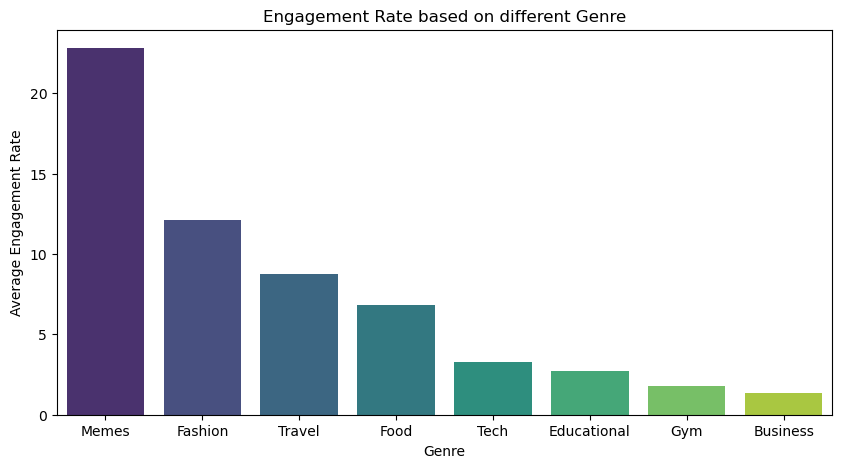

In [32]:
genre_data=insta_data.groupby('Genre')['EngagementRate'].mean().reset_index().sort_values('EngagementRate', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(data=genre_data,x ='Genre',y='EngagementRate',palette='viridis')
plt.title('Engagement Rate based on different Genre')
plt.xlabel('Genre')
plt.ylabel('Average Engagement Rate')
plt.show()

From this chart, it’s clear that Memes absolutely dominate with the highest engagement rate. After that, Fashion, Travel, and Food perform decently. Genres like Tech, Educational, Gym, and Business have much lower engagement.
Overall, fun and relatable content seems to attract way more interaction than informational or niche content

### Views based on different Genre

C:\Users\juver\AppData\Local\Temp\ipykernel_12132\1970371132.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=genre_data,x ='Genre',y='Plays',palette='viridis')


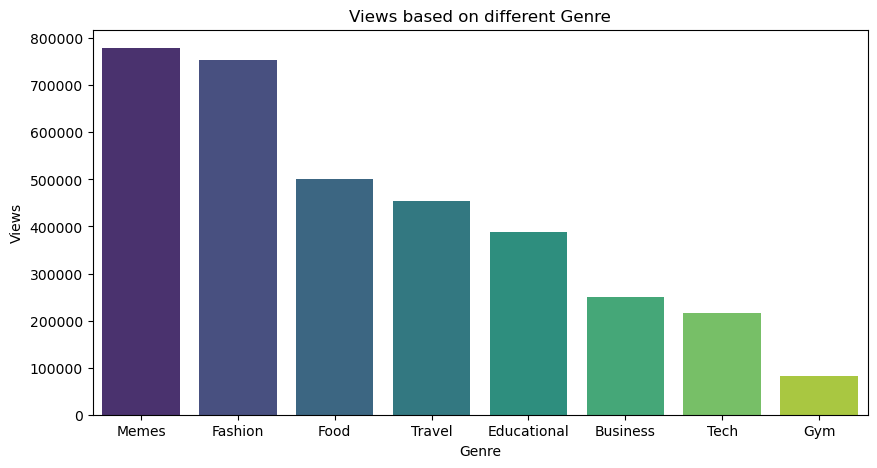

In [31]:
genre_data=insta_data.groupby('Genre')['Plays'].mean().reset_index().sort_values('Plays', ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(data=genre_data,x ='Genre',y='Plays',palette='viridis')
plt.title('Views based on different Genre')
plt.xlabel('Genre')
plt.ylabel('Views')
plt.show()

From the chart, Memes and Fashion reels get the highest reach, followed by Food and Travel. Educational and Business genres sit in the middle, while Tech and Gym get the least views.
This gives me a clear idea of which content types naturally get pushed more on Instagram in terms of visibility.

### Average Likes vs Plays by Genre (Log Scale)

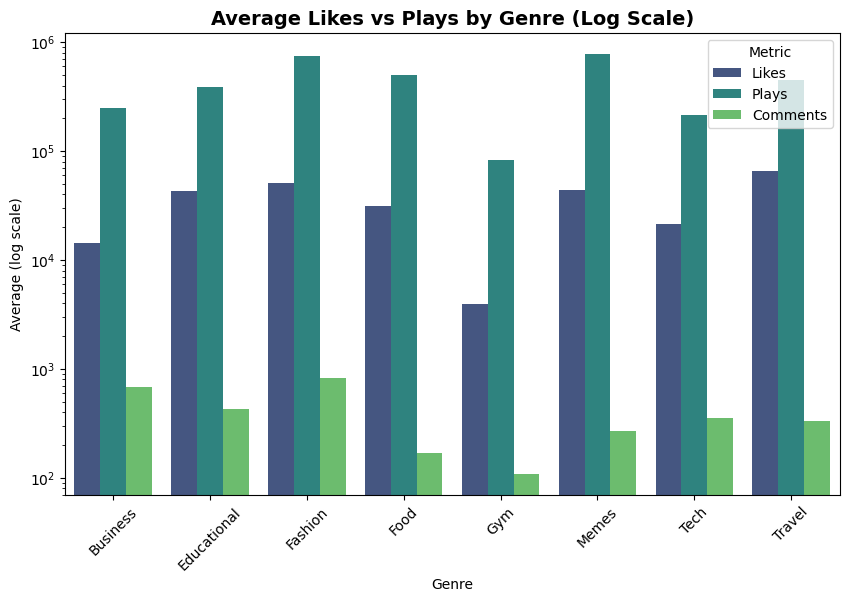

In [14]:
genre_metrics = insta_data.groupby('Genre')[['Likes', 'Plays','Comments']].mean().reset_index()
genre_melted = genre_metrics.melt(id_vars='Genre', var_name='Metric', value_name='AverageValue')

plt.figure(figsize=(10,6))
sns.barplot(data=genre_melted, x='Genre', y='AverageValue', hue='Metric', palette='viridis')
plt.yscale('log')  # Log scale to balance large values

plt.title('Average Likes vs Plays by Genre (Log Scale)', fontsize=14, fontweight='bold')
plt.xlabel('Genre')
plt.ylabel('Average (log scale)')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.show()


I compared the counts of Likes, Plays (Views), and Comments across different genres. Overall, Memes, Fashion, and Travel perform the best in both reach and engagement. Food and Educational content show moderate performance. Business, Tech, and Gym have the lowest numbers, which means they may need more creative strategies to improve.

### Final Genre Insights:

### Engagement Rate
- **Memes** have the highest engagement rate, people not only watch them but also interact more.

### Views/Reach
- **Fashion** and **Memes** get the highest average views.
- **Travel** and **Food** also perform well and get pushed more on Explore.

### Likes vs Plays vs Comments
- **Plays** are the highest for every genre.
- **Likes** follow the same pattern (Memes, Fashion, Travel on top).
- **Comments** are the lowest across all genres.

### Overall Performance Summary
- **Memes** → Best engagement  
- **Fashion** → Highest reach  
- **Travel** → Strong in both likes and views  
- **Food / Educational** → Middle performance  
- **Tech / Business / Gym** → Lowest performance  


## Creator-Type & Viral Performance Analysis
Here I analysed how different creator categories perform and identified viral reels based on top 5% view counts.


### Engagement by Creator Type

C:\Users\juver\AppData\Local\Temp\ipykernel_12132\1612169581.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  followingtype = insta_data.groupby('Creator_type')['EngagementRate'].mean().reset_index()
C:\Users\juver\AppData\Local\Temp\ipykernel_12132\1612169581.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=followingtype,x='Creator_type',y='EngagementRate',palette='viridis')


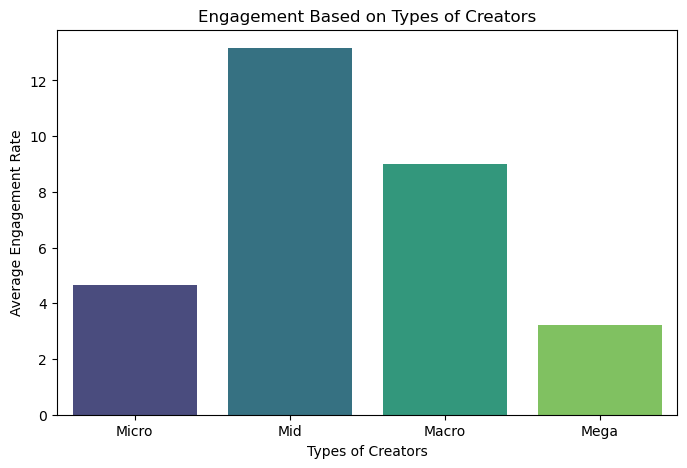

In [35]:
labels=['Micro','Mid','Macro','Mega']
bins=[1000,50000,250000,1000000,np.inf]
insta_data['Creator_type']=pd.cut(insta_data['Followers'],bins=bins,labels=labels)
followingtype = insta_data.groupby('Creator_type')['EngagementRate'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=followingtype,x='Creator_type',y='EngagementRate',palette='viridis')
plt.title('Engagement Based on Types of Creators')
plt.xlabel('Types of Creators')
plt.ylabel('Average Engagement Rate')
plt.show()

This graph shows that Mid creators have the highest engagement rate. Micro and Macro creators are in the middle, and Mega creators have the lowest engagement. Basically, mid-sized accounts have a more active audience, while very big accounts naturally get lower engagement percentages.

### Average Views by Creator Type

C:\Users\juver\AppData\Local\Temp\ipykernel_12132\3697427430.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  followingtype = insta_data.groupby('Creator_type')['Plays'].mean().reset_index()
C:\Users\juver\AppData\Local\Temp\ipykernel_12132\3697427430.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=followingtype,x='Creator_type',y='Plays',palette='viridis')


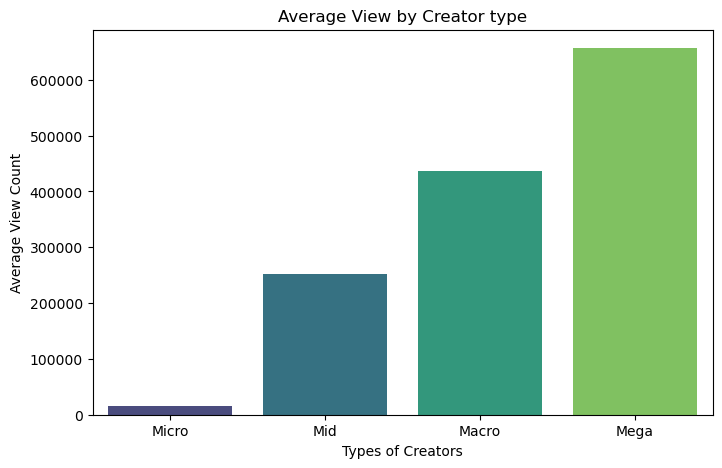

In [37]:
followingtype = insta_data.groupby('Creator_type')['Plays'].mean().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=followingtype,x='Creator_type',y='Plays',palette='viridis')
plt.title('Average View by Creator type')
plt.xlabel('Types of Creators')
plt.ylabel('Average View Count')
plt.show()

### Identifying Viral Reels (Top 5% by Views)

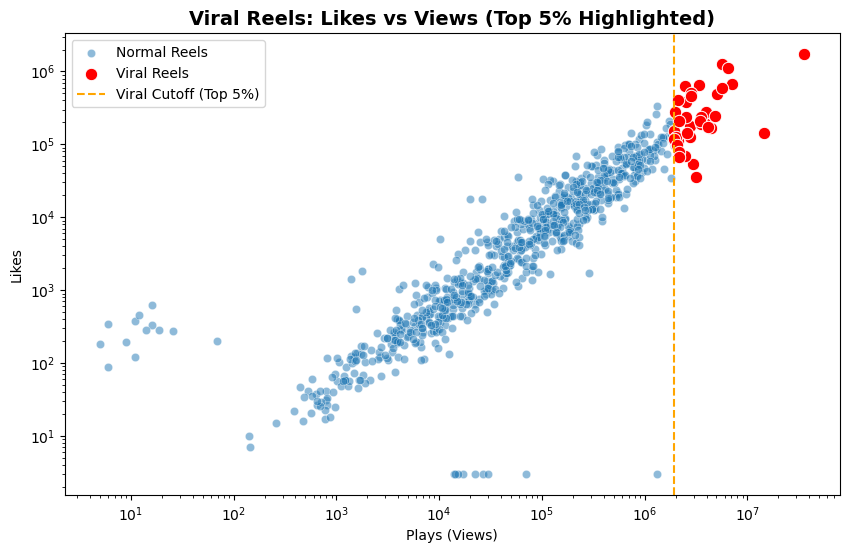

In [33]:
viral_threshold = insta_data['Plays'].quantile(0.95)
viral_reels = insta_data[insta_data['Plays'] >= viral_threshold]

plt.figure(figsize=(10,6))
sns.scatterplot(data=insta_data, x='Plays', y='Likes', alpha=0.5, label='Normal Reels')
sns.scatterplot(data=viral_reels, x='Plays', y='Likes', color='red', s=80, label='Viral Reels')
plt.axvline(viral_threshold, color='orange', linestyle='--', label='Viral Cutoff (Top 5%)')
plt.title('Viral Reels: Likes vs Views (Top 5% Highlighted)', fontsize=14, fontweight='bold')
plt.xlabel('Plays (Views)')
plt.ylabel('Likes')
plt.legend()
plt.xscale('log')  
plt.yscale('log')
plt.show()


This plot shows which reels fall into the top 5% of views, marked in red. The orange line is the viral cutoff.

### Insights:
- Viral reels have very high views (1M+) and also get a lot more likes.
- Normal reels follow a steady pattern: more views → more likes, but not at viral levels.
- Viral reels clearly stand out with much stronger engagement compared to the rest.

### Top Creators with the Most Viral Reels

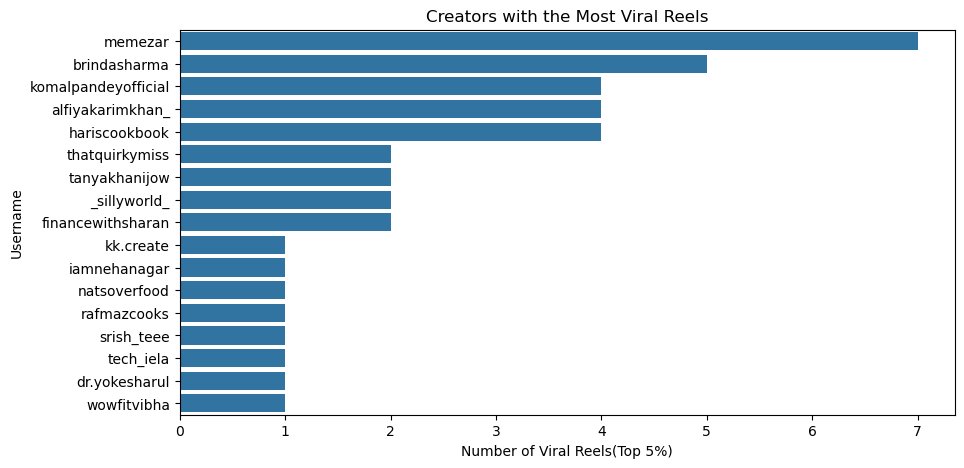

In [38]:
viral_threshold=insta_data['Plays'].quantile(0.95)
viral_reels=insta_data[insta_data['Plays']>=viral_threshold]
#viral_reels.head()
top_creators=viral_reels.groupby('Username')['Plays'].count().reset_index(name='ViralReelCount').sort_values('ViralReelCount',ascending=False)
plt.figure(figsize=(10,5))
sns.barplot(data=top_creators,x='ViralReelCount',y='Username')
plt.title('Creators with the Most Viral Reels')
plt.xlabel('Number of Viral Reels(Top 5%)')
plt.ylabel('Username')
plt.show()

This chart shows which creators have the highest number of viral reels (top 5% by views).

### Insights:
- @memezar is way ahead with the most viral reels.
- Creators like @brindasharma, @komalpandeyofficial, @alfiyakarimkhan_, and @hariscookbook also produce multiple viral reels.
- Most other creators only have 1–2 viral reels, showing that going viral is rare.
- We can observe that the top creators clearly have content that consistently grabs massive reach.

## Posting Behaviour and Best Time to Post Analysis
Here I analysed how the posting day, posting hour, and posting frequency affect engagement rate.

### Engagement Rate by Day of the Week

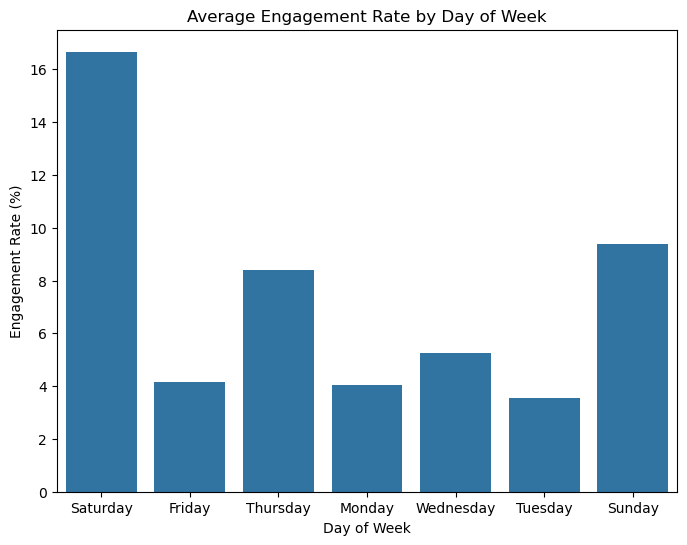

In [39]:
plt.figure(figsize=(8,6))
sns.barplot(data=insta_data, x='DayOfWeek', y='EngagementRate', errorbar=None)
plt.title('Average Engagement Rate by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Engagement Rate (%)')
plt.show()

From this graph, it’s clear that Saturday gets the highest engagement rate by far. Sunday and Thursday also perform well. Tuesday and Friday have the lowest engagement.
Overall, weekends work the best if you want more interaction on reels.

### Engagement Rate by Posting Hour

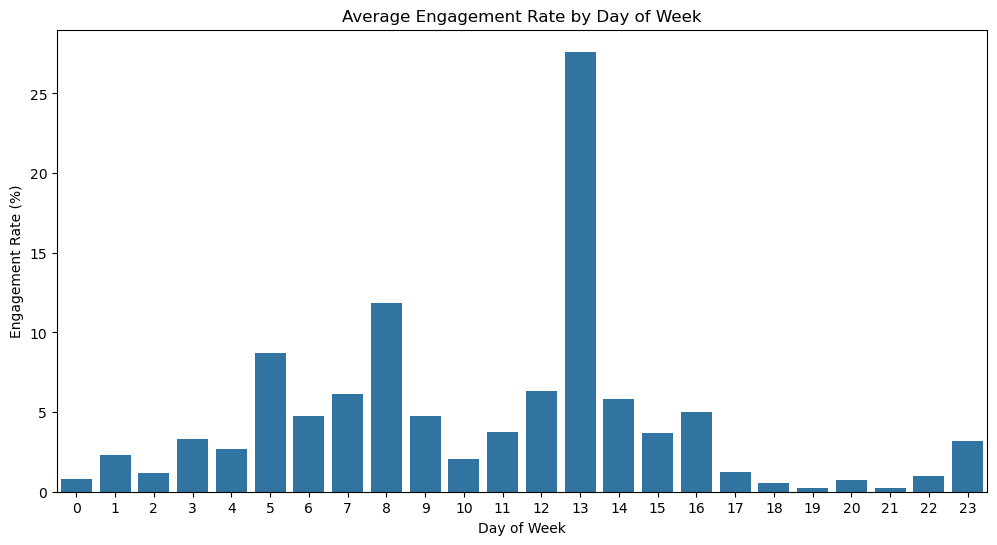

In [27]:
plt.figure(figsize=(12,6))
sns.barplot(data=insta_data, x='PostingHour', y='EngagementRate', errorbar=None)
plt.title('Average Engagement Rate by Day of Week')
plt.xlabel('time')
plt.ylabel('Engagement Rate (%)')
plt.show()

From this chart, it’s pretty clear that most hours don’t get much engagement, but 1 PM shoots up like crazy. A few hours like 5 PM, 7 PM, and 11 AM are okay, but nothing comes close to that 1 PM spike.
Basically, posting around mid-day seems to get the best engagement, while early mornings and late nights are pretty weak.

### Posting Frequency by Day

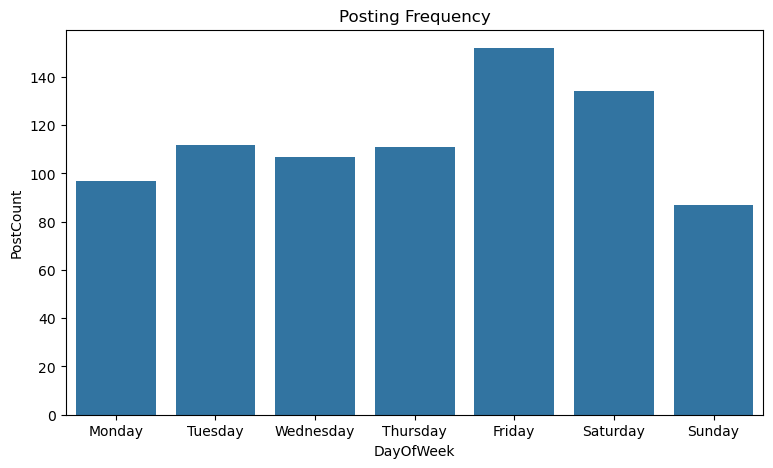

In [41]:
plt.figure(figsize=(9,5))
post_per_day=insta_data['DayOfWeek'].value_counts().reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']).reset_index()
post_per_day.columns=['DayOfWeek','PostCount']
sns.barplot(data=post_per_day,x='DayOfWeek',y='PostCount')
plt.title('Posting Frequency')
plt.show()

Looking at this graph, creators post the most on Friday, followed by Saturday, Tuesday, and Thursday. Monday and Wednesday are in the middle, and Sunday has the lowest posting frequency.
So basically, the end of the week is the busiest for posting, while Sunday is the most chill day with fewer uploads.

### Posting Frequency vs Engagement

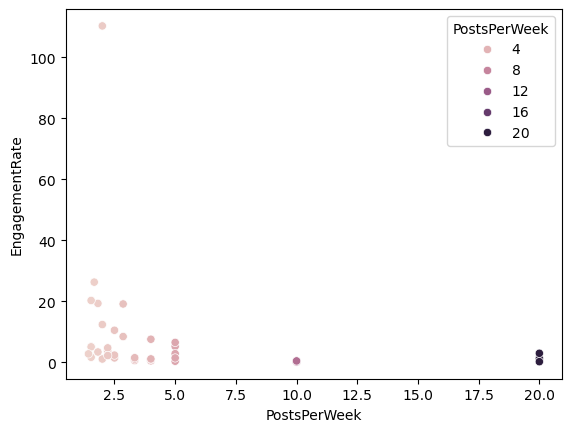

In [40]:
insta_data['Week']=insta_data['Post_date'].dt.isocalendar().week
weekly_posts=insta_data.groupby(['Username','Week']).size().reset_index(name='PostsPerWeek')
avg_eng=insta_data.groupby('Username')['EngagementRate'].mean().reset_index()
merged=(weekly_posts.groupby('Username')['PostsPerWeek'].mean().reset_index().merge(avg_eng,on='Username'))
sns.scatterplot(data=merged,x='PostsPerWeek',y='EngagementRate',hue='PostsPerWeek')
plt.show()

From this graph, it’s pretty clear that posting more doesn’t automatically give you better engagement. Most creators who post around 2–5 times a week stay in the normal engagement range. But the people posting 10+ times a week don’t really see any boost, some even drop to almost zero engagement.
So yeah, posting too much doesn’t help. A steady 2–5 posts per week seems to work better than spamming 15–20 reels.

## Caption, Hashtag & Content-Style Analysis
Here I analysed how caption length, hashtag usage, and video duration affect engagement on Instagram reels.

### Caption Length vs Engagement

C:\Users\juver\AppData\Local\Temp\ipykernel_12132\2205342026.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  caption_insights = insta_data.groupby('Caption_types')[['Likes', 'Comments', 'EngagementRate']].mean().reset_index()
C:\Users\juver\AppData\Local\Temp\ipykernel_12132\2205342026.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=caption_insights, x='Caption_types', y='Likes', ax=ax[0], palette='mako')
C:\Users\juver\AppData\Local\Temp\ipykernel_12132\2205342026.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for th

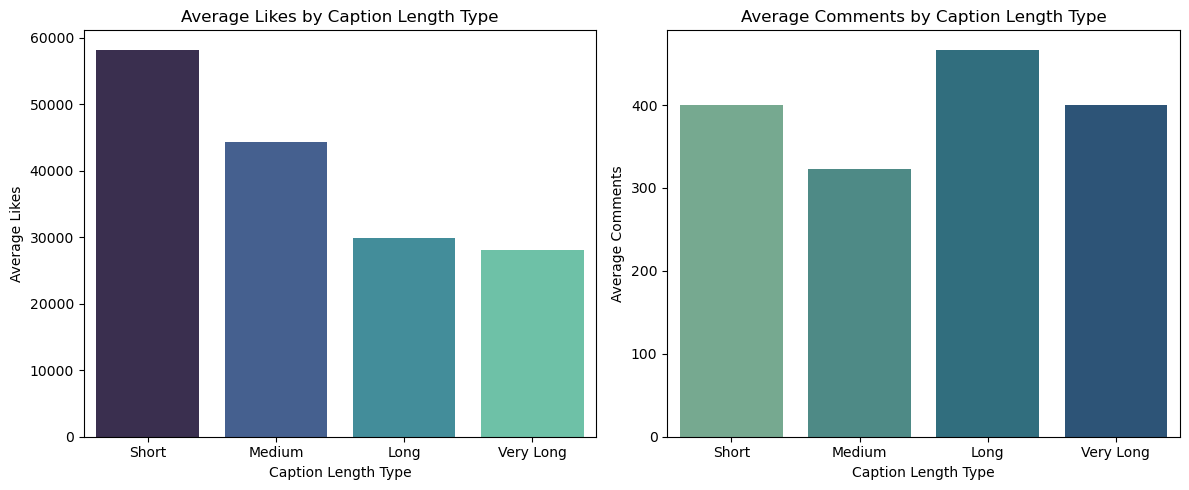

C:\Users\juver\AppData\Local\Temp\ipykernel_12132\2205342026.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=caption_insights, x='Caption_types', y='EngagementRate', palette='viridis')


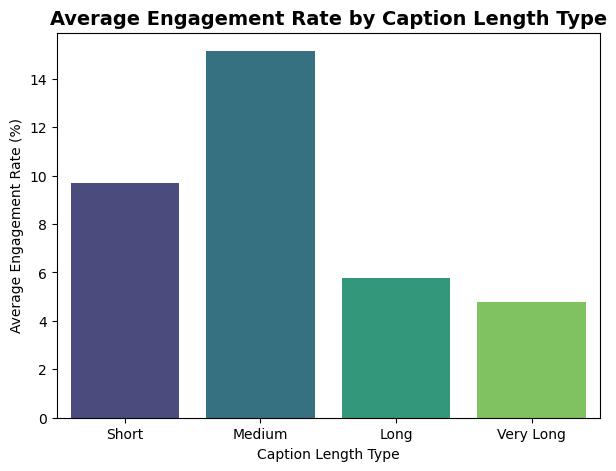

In [43]:
labels=['Short','Medium','Long','Very Long']
bins=[0,50,150,300,np.inf]
insta_data['Caption_types']=pd.cut(insta_data['CaptionLength'],bins=bins,labels=labels)
caption_insights = insta_data.groupby('Caption_types')[['Likes', 'Comments', 'EngagementRate']].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(data=caption_insights, x='Caption_types', y='Likes', ax=ax[0], palette='mako')
ax[0].set_title('Average Likes by Caption Length Type')
ax[0].set_xlabel('Caption Length Type')
ax[0].set_ylabel('Average Likes')

sns.barplot(data=caption_insights, x='Caption_types', y='Comments', ax=ax[1], palette='crest')
ax[1].set_title('Average Comments by Caption Length Type')
ax[1].set_xlabel('Caption Length Type')
ax[1].set_ylabel('Average Comments')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
sns.barplot(data=caption_insights, x='Caption_types', y='EngagementRate', palette='viridis')
plt.title('Average Engagement Rate by Caption Length Type', fontsize=14, fontweight='bold')
plt.xlabel('Caption Length Type')
plt.ylabel('Average Engagement Rate (%)')
plt.show()

From these graphs, it’s pretty clear that caption length actually matters. Short captions get the highest likes because people like quick, easy captions. Long captions get the most comments, probably because they make people talk more. For overall engagement rate, medium captions perform the best since they give enough info without being too long.

So basically, short captions are great for likes, long captions work for comments, and medium captions are the best for overall engagement.

### Most Frequent Hashtags

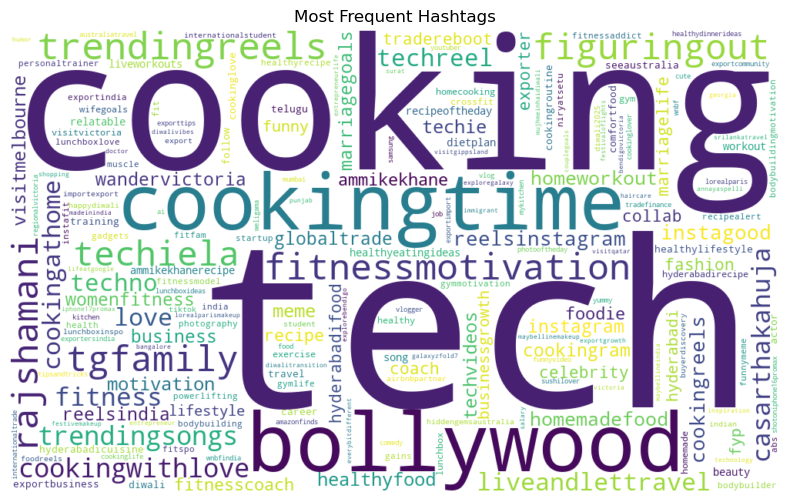

In [46]:
tokens= [s.strip().lower() for t in insta_data['Hashtags'].dropna()
        for s in str(t).split(',')
        if s.strip()]
stop=["ad", "reels", "reelitfeelit", "viral", "trending", "foryou", "explore", "explorepage"]
tokens=[t for t in tokens if t not in stop]
text=' '.join(tokens)
wordcloud=WordCloud( width=1000, height=600,background_color='white', collocations=False,random_state=42).generate(text)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Hashtags')
plt.show()

This word cloud basically shows which hashtags pop up the most in all the reels. The bigger the word, the more it’s used. Cooking, tech, bollywood, fitness, and travel hashtags are everywhere. So yeah, these are the main themes creators keep using to get more reach.

### Hashtags that Drive High Engagement

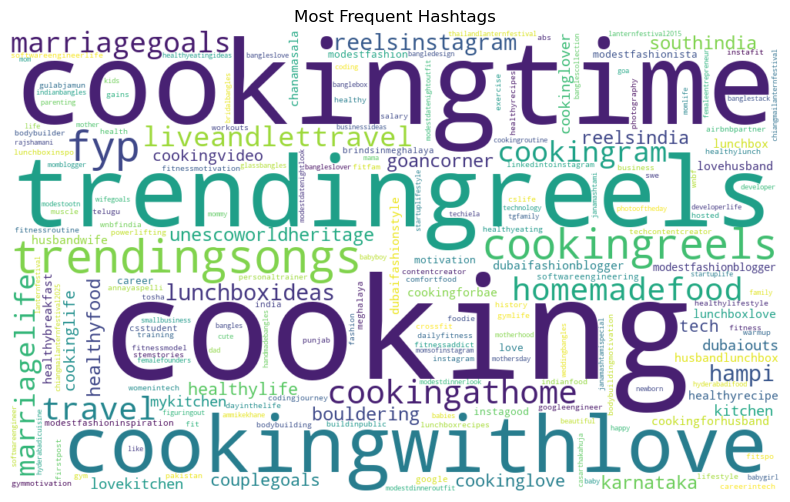

In [56]:
stop = {"ad","reels","reelitfeelit","viral","trending","foryou","explore","explorepage"}
freq=Counter()
for _,rows in insta_data.dropna(subset=['Hashtags']).iterrows():
    w=float(rows.get('EngagementRate',0) or 0.0)
    if w<=0:
        continue
    for tags in str(rows['Hashtags']).split(','):
        t=tags.strip().lower()
        if t and t not in stop:
            freq[t]+=w
wordcloud=WordCloud( width=1000, height=600,background_color='white', collocations=False,random_state=42).generate_from_frequencies(freq)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Hashtags')
plt.show()          

This word cloud shows which hashtags appear the most in reels that have high engagement. Here I’m not just counting how many times a hashtag is used, I’m giving more weight to the hashtags that come from reels performing really well.

From the cloud, cooking hashtags clearly dominate. Words like cooking, cookingtime, cookingwithlove and cookingreels show up the biggest. You can also see trendingreels, homemadefood, travel and fitness appearing a lot.

So basically, these are the hashtags that usually show up in reels that get strong engagement, not just the ones people randomly use.

### Video Duration vs Engagement Rate

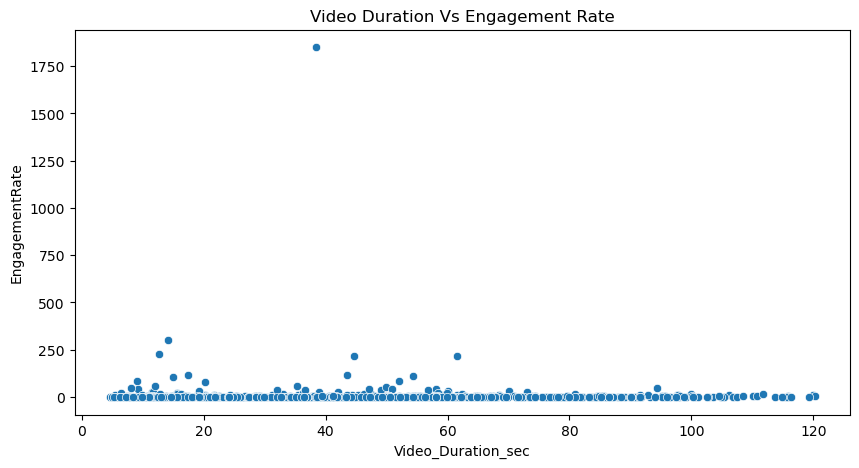

In [47]:
video_duration=insta_data[insta_data['Video_Duration_sec']<insta_data['Video_Duration_sec'].quantile(0.95)]
plt.figure(figsize=(10,5))
sns.scatterplot(data=video_duration, x='Video_Duration_sec', y='EngagementRate')
plt.title('Video Duration Vs Engagement Rate')
plt.show()

Looking at this scatter plot, there isn’t a strong connection between video length and engagement rate. Most reels, whether short or long, sit in the same low engagement range. There are a few random spikes, but they seem like outliers rather than a pattern. Overall, reel length doesn’t really decide engagement. Content quality matters way more than how many seconds the video is.

## Time-Based Engagement Analysis
Here I’m checking how engagement changes over days, months, and across top creators to understand overall performance trends.

### Daily Engagement Trend Over Time

In [50]:
insta_data['Date']=insta_data['Post_date'].dt.date
insta_data['Year']=insta_data['Post_date'].dt.year

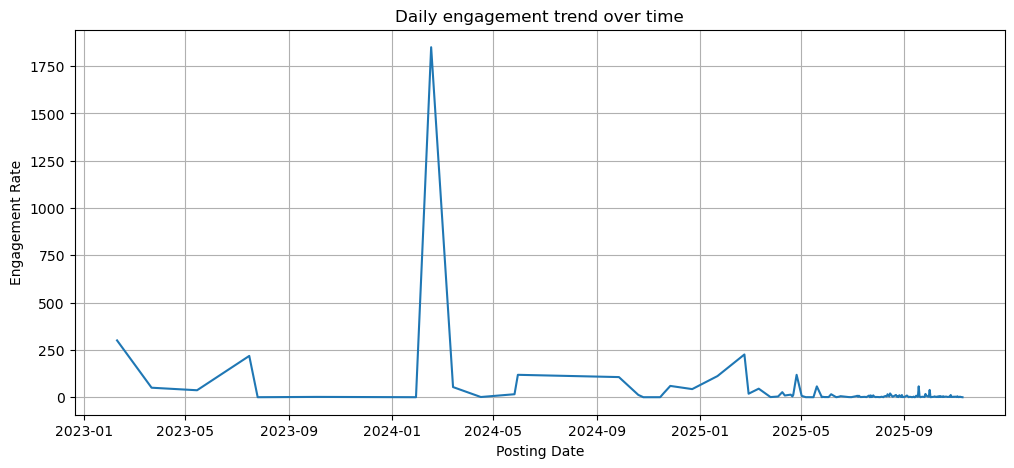

In [51]:
daily_eng=insta_data.groupby('Date')['EngagementRate'].mean().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=daily_eng,x='Date',y='EngagementRate')
plt.title('Daily engagement trend over time')
plt.xlabel('Posting Date')
plt.ylabel('Average Engagement Rate')
plt.grid(True)
plt.show()

This graph shows how engagement changes day by day, and it jumps around quite a bit. There is one massive spike where a reel clearly went viral, and after that everything settles back to normal with small ups and downs. Overall, engagement doesn’t stay consistent because it depends a lot on what kind of reel was posted and which ones randomly performed well.

### Monthly Engagement Trend

C:\Users\juver\AppData\Local\Temp\ipykernel_12132\1741020851.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  monthly_eng=insta_data.groupby('Month')['EngagementRate'].mean().reset_index()


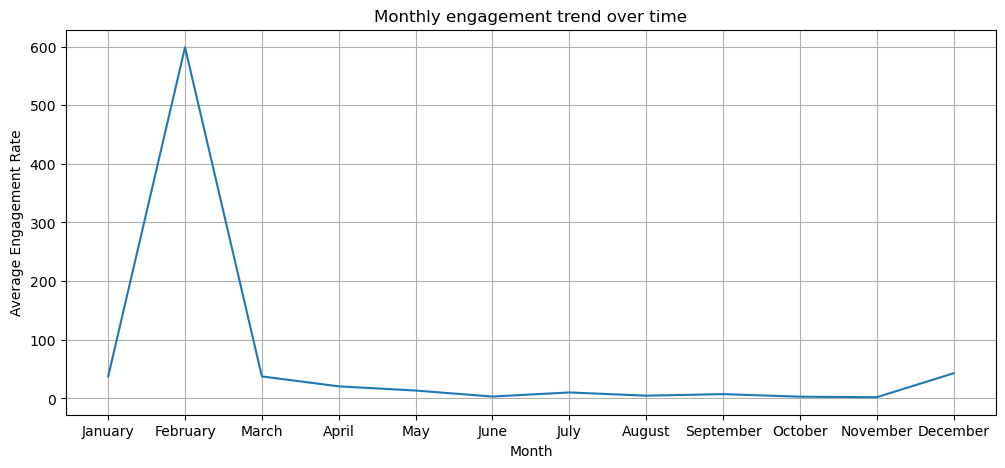

In [52]:
month_order=[ "January", "February", "March", "April", "May", "June","July", "August", "September", "October", "November", "December"]
insta_data['Month']=pd.Categorical(insta_data['Month'],categories=month_order,ordered=True)
monthly_eng=insta_data.groupby('Month')['EngagementRate'].mean().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_eng,x='Month',y='EngagementRate')
plt.title('Monthly engagement trend over time')
plt.xlabel('Month')
plt.ylabel('Average Engagement Rate')
plt.grid(True)
plt.show()

This graph shows how engagement changes month by month. February stands out with a huge spike, meaning something posted that month performed really well compared to everything else. After that, engagement drops and stays low and steady for the rest of the year. December picks up a bit again, but nothing close to February. Overall, engagement doesn’t follow a smooth monthly pattern, it mostly depends on a few reels that suddenly do really well.

### Top 5 Percent Engagement Spikes

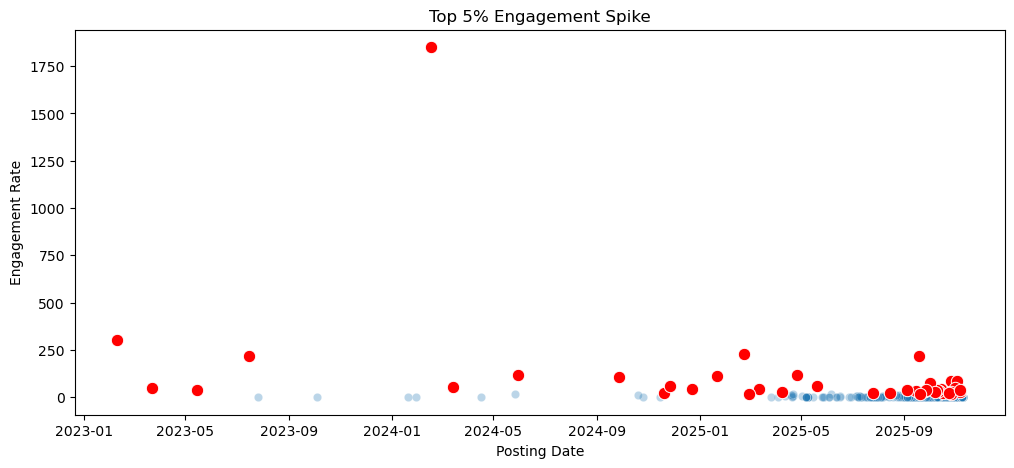

In [53]:
# detecting viral spikes 
viral_eng=insta_data[insta_data['EngagementRate']>=insta_data['EngagementRate'].quantile(0.95)]
plt.figure(figsize=(12,5))
sns.scatterplot(data=insta_data,x='Date',y='EngagementRate',alpha=0.3)
sns.scatterplot(data=viral_eng,x='Date',y='EngagementRate',color='red', s=80)
plt.title('Top 5% Engagement Spike')
plt.xlabel('Posting Date')
plt.ylabel('Engagement Rate')
plt.show()

This plot highlights the reels that fall in the top 5 percent of engagement. The red points are the reels that performed way better than the rest. You can clearly see a few huge spikes where engagement jumped like crazy, especially around early 2024. The rest of the points stay low and scattered. This shows that only a small number of reels drive big engagement jumps, while most reels stay in the normal range.

### Engagement Trend of Top Creators

C:\Users\juver\AppData\Local\Temp\ipykernel_12132\806256173.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top5_creator=filtered.groupby(['Username','Month'])['EngagementRate'].mean().reset_index()


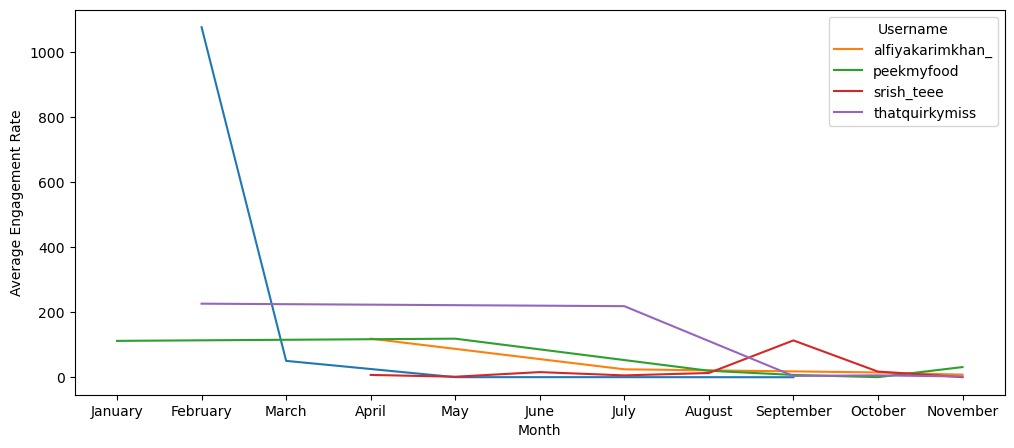

In [55]:
top5=insta_data.groupby('Username')['EngagementRate'].mean().sort_values(ascending=False).head(5).reset_index()
filtered=insta_data[insta_data['Username'].isin(top5['Username'])]
top5_creator=filtered.groupby(['Username','Month'])['EngagementRate'].mean().reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=top5_creator,x='Month',y='EngagementRate',hue='Username')
plt.xlabel('Month')
plt.ylabel('Average Engagement Rate')
plt.show() 

This graph shows how the top five creators perform across different months. Each creator has their own pattern. One of them has a huge spike early in the year and then drops down, while others stay more stable but lower. Overall, it just shows that engagement is very creator-dependent and not everyone stays consistent every month. Some months they do great, other months they barely get any engagement.

## Regression Check to See What Actually Impacts Engagement

In [61]:
insta_data['HashtagsCount']=insta_data['Hashtags'].apply(
    lambda x: len(x.split(',')) if isinstance(x,str) and x.strip() else 0
)
x=insta_data[['HashtagsCount', 'CaptionLength', 'Video_Duration_sec', 'PostingHour', 'Followers']]
y=insta_data['EngagementRate']
x=sm.add_constant(x)
model=sm.OLS(y,x).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         EngagementRate   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.3433
Date:                Sat, 15 Nov 2025   Prob (F-statistic):              0.887
Time:                        23:50:42   Log-Likelihood:                -4513.6
No. Observations:                 800   AIC:                             9039.
Df Residuals:                     794   BIC:                             9067.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 10.7147      7

So this regression basically says nothing here is really affecting engagement. Hashtag count, caption length, video duration, posting hour, followers… none of them are actually doing anything. The R-squared is almost zero, so the model can’t explain engagement at all.

Pretty much, it proves that engagement doesn’t come from these basic stats. It comes from how good or catchy the reel is, trends, and just overall content quality. The numbers alone don’t decide it.

### Actual vs Predicted

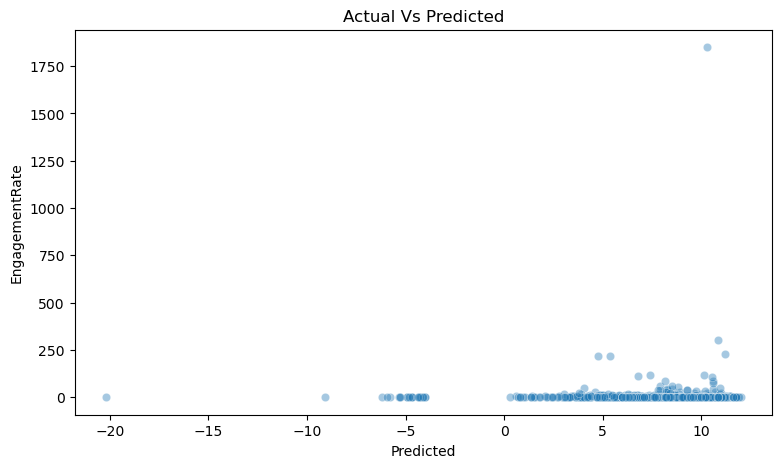

In [63]:
insta_data['Predicted']=model.predict(x)
plt.figure(figsize=(9,5))
sns.scatterplot(data=insta_data, x='Predicted',y='EngagementRate', alpha=0.4)
plt.title('Actual Vs Predicted')
plt.show()

This plot basically shows that the model isn’t able to predict engagement at all. The predicted values are all squeezed into a small range, while the actual engagement rates are all over the place, with some reels shooting really high.

If the model was good, the points would line up in a nice pattern. But here, everything is scattered randomly. It just confirms that engagement can’t be predicted using simple features like hashtags, caption length, duration, followers or posting hour.

In short, the model has no idea what’s going on, and engagement is way too messy for a basic linear regression.

## *Conclusion*
After checking everything like genres, creator types, captions, hashtags, timing and even running a regression, it’s clear that Instagram engagement doesn’t come from one simple factor. Memes, fashion and travel always do better, while business, tech and gym stay on the lower side. Mid-level creators actually get the best engagement, and mega creators don’t perform as well because their audience isn’t always super active. Captions, hashtags and video length don’t really decide performance. Medium captions help a bit, but overall the real boost comes from content quality, not how long the video is or how many hashtags you use.

Time-wise trends are all over the place. Some reels randomly blow up and create big spikes, while most stay normal. Weekends, especially Saturday, do slightly better, but nothing is guaranteed. The regression basically confirmed everything by showing that numeric features like hashtag count, caption length, video duration, posting hour or followers can’t predict engagement at all. In the end, engagement depends way more on creativity, niche and how interesting or relatable the reel feels. Good content, good timing and consistency matter way more than the small metrics.